In [1]:
from tqdm import tqdm
tqdm.pandas()

import numpy as np
import os

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


import matplotlib.pyplot as plt

import transformers
from transformers import AutoModel, BertTokenizer

import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [2]:
df = pd.read_csv('L.csv' ,delimiter=';', encoding='cp1251')

df['Target'] = df['Group']


#one hot encoding
amount_of_classes = len(df['Target'].unique())

encoder = sklearn.preprocessing.LabelBinarizer()
y = encoder.fit_transform(df['Target'])


y = pd.DataFrame(y)
# df = pd.concat([df, y], axis=1)
columns_to_convert = [int(i) for i in range(amount_of_classes)]


df['Target_2'] = df['Cat'] 
amount_of_classes_2 = len(df['Target_2'].unique())
encoder_2 = sklearn.preprocessing.LabelBinarizer()
y_2 = encoder_2.fit_transform(df['Target_2'])
y_2 = pd.DataFrame(y_2, columns=[str(i)+'_1' for i in range(amount_of_classes_2)])
df = pd.concat([df, y, y_2], axis=1)
columns_to_convert_2 = [str(i)+'_1' for i in range(amount_of_classes_2)]

print('amount', amount_of_classes, amount_of_classes_2)

amount 22 97


In [3]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.25, random_state=42)


train_x = train['Desc']
train_y = train[columns_to_convert+columns_to_convert_2].to_numpy()

test_x = test['Desc']
test_y = test[columns_to_convert+columns_to_convert_2].to_numpy()


val_x = val['Desc']
val_y = val[columns_to_convert+columns_to_convert_2].to_numpy()

In [4]:
tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")
bert = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased-sentence")
bert.to(device)


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

In [5]:

'''
new_vocabulary = {}

for i in tqdm(range(int(len(df)))):
    deb = str(df['Desc'][i]).split()
    for j in deb:
        if len(tokenizer.encode(j)) > 3:
            count = new_vocabulary.get(j, 0)
            new_vocabulary.update({j:count+1})

new_vocabulary = (sorted(new_vocabulary.items(), key=lambda item: -item[1]))
to_learn = []
for i in new_vocabulary:
    if i[1]>5:
        to_learn.append(i[0])
to_learn = set(to_learn) - set(tokenizer.vocab.keys())
tokenizer.add_tokens(list(to_learn))
bert.resize_token_embeddings(len(tokenizer))
'''

"\nnew_vocabulary = {}\n\nfor i in tqdm(range(int(len(df)))):\n    deb = str(df['Desc'][i]).split()\n    for j in deb:\n        if len(tokenizer.encode(j)) > 3:\n            count = new_vocabulary.get(j, 0)\n            new_vocabulary.update({j:count+1})\n\nnew_vocabulary = (sorted(new_vocabulary.items(), key=lambda item: -item[1]))\nto_learn = []\nfor i in new_vocabulary:\n    if i[1]>5:\n        to_learn.append(i[0])\nto_learn = set(to_learn) - set(tokenizer.vocab.keys())\ntokenizer.add_tokens(list(to_learn))\nbert.resize_token_embeddings(len(tokenizer))\n"

In [6]:
tokens_train = tokenizer.batch_encode_plus(train_x.astype('str'), max_length=10,
                                          padding='max_length', truncation = True)
tokens_val = tokenizer.batch_encode_plus(val_x.astype('str'), max_length=10,
                                          padding='max_length', truncation = True)
tokens_test = tokenizer.batch_encode_plus(test_x.astype('str'), max_length=10,
                                          padding='max_length', truncation = True)


train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_y)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_y)

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_y)

In [7]:
batch_size = 8

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size = batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size = batch_size)

test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size = batch_size)


# !

In [8]:
for param in bert.parameters():
    param.requires_grad = False
    

    
class BERT_Arch(nn.Module):

    def __init__(self):
        super(BERT_Arch, self).__init__()
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512,amount_of_classes)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, cls_hs):
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [9]:
epochs = 30
cross_entropy = nn.CrossEntropyLoss()

model = BERT_Arch()

model = model.to(device)
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr= 1e-3)

model_1_path = os.path.join('..', 'model', 'model1.pt')
model_1_path

C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


'..\\model\\model1.pt'

In [10]:
def evaluate():
    model.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []

    for step, batch in tqdm(enumerate(val_dataloader), total = len(val_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        
        labels = labels[:amount_of_classes]

        with torch.no_grad():
            _, cls_hs = bert(sent_id, mask, return_dict = False)
            preds = model(cls_hs)

            labels = torch.argmax(labels, dim=1)

            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

    avg_loss = total_loss / len(val_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)

    return avg_loss, total_preds

In [11]:
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds = []

    for step, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        batch = [r.to(device) for r   in batch]
        sent_id, mask, labels = batch
        
        labels = labels[:amount_of_classes]
        
        model.zero_grad()
        _, cls_hs = bert(sent_id, mask, return_dict = False)
        preds = model(cls_hs)

        labels = torch.argmax(labels, dim=1)

 
        loss = cross_entropy(preds, labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)
        

    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)

    return avg_loss, total_preds

In [13]:
best_valid_loss = float('inf')

train_losses = []
valid_losses = []

for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))

    train_loss, _ = train()
    valid_loss, _ = evaluate()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_1_path)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Validation loss: {valid_loss:.3f}')


 Epoch1 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:18<00:00, 69.54it/s]



Training loss: 0.146
Validation loss: 0.100

 Epoch2 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:18<00:00, 70.23it/s]



Training loss: 0.119
Validation loss: 0.098

 Epoch3 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:18<00:00, 70.12it/s]



Training loss: 0.110
Validation loss: 0.112

 Epoch4 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:18<00:00, 70.42it/s]



Training loss: 0.103
Validation loss: 0.093

 Epoch5 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:18<00:00, 68.36it/s]



Training loss: 0.099
Validation loss: 0.088

 Epoch6 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:18<00:00, 70.27it/s]



Training loss: 0.094
Validation loss: 0.085

 Epoch7 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:18<00:00, 69.97it/s]



Training loss: 0.088
Validation loss: 0.088

 Epoch8 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:18<00:00, 69.56it/s]



Training loss: 0.088
Validation loss: 0.087

 Epoch9 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:17<00:00, 71.15it/s]



Training loss: 0.086
Validation loss: 0.100

 Epoch10 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:18<00:00, 70.52it/s]



Training loss: 0.086
Validation loss: 0.092

 Epoch11 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:18<00:00, 69.86it/s]



Training loss: 0.082
Validation loss: 0.084

 Epoch12 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 88.59it/s]



Training loss: 0.080
Validation loss: 0.096

 Epoch13 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 88.62it/s]



Training loss: 0.079
Validation loss: 0.090

 Epoch14 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 88.59it/s]



Training loss: 0.077
Validation loss: 0.112

 Epoch15 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 88.57it/s]



Training loss: 0.077
Validation loss: 0.090

 Epoch16 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 88.57it/s]



Training loss: 0.076
Validation loss: 0.087

 Epoch17 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 88.54it/s]



Training loss: 0.074
Validation loss: 0.088

 Epoch18 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 88.53it/s]



Training loss: 0.074
Validation loss: 0.114

 Epoch19 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 88.58it/s]



Training loss: 0.074
Validation loss: 0.084

 Epoch20 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 88.60it/s]



Training loss: 0.071
Validation loss: 0.094

 Epoch21 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 88.60it/s]



Training loss: 0.073
Validation loss: 0.087

 Epoch22 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 88.65it/s]



Training loss: 0.068
Validation loss: 0.109

 Epoch23 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 88.64it/s]



Training loss: 0.067
Validation loss: 0.087

 Epoch24 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 88.31it/s]



Training loss: 0.068
Validation loss: 0.097

 Epoch25 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 88.70it/s]



Training loss: 0.067
Validation loss: 0.105

 Epoch26 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 88.69it/s]



Training loss: 0.065
Validation loss: 0.102

 Epoch27 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 88.68it/s]



Training loss: 0.067
Validation loss: 0.090

 Epoch28 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 88.70it/s]



Training loss: 0.063
Validation loss: 0.094

 Epoch29 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 88.74it/s]



Training loss: 0.065
Validation loss: 0.097

 Epoch30 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 88.70it/s]


Training loss: 0.064
Validation loss: 0.093


In [14]:

model.load_state_dict(torch.load(model_1_path))

<All keys matched successfully>

In [15]:
#my evaluation after training

model.eval()
model.to(device)
count_true = 0
count_total = 0
for step, batch in tqdm(enumerate(test_dataloader), total = len(test_dataloader)):
    batch = [t.to(device) for t in batch]
    sent_id, mask, labels = batch
    labels= labels[:amount_of_classes]
    
    with torch.no_grad():
        _, cls_hs = bert(sent_id, mask, return_dict=False)
        preds = model(cls_hs)
        preds = torch.argmax(preds, dim=1)
        preds = preds.cpu().numpy()
        labels = torch.argmax(labels, dim=1)
        labels = list((labels).cpu().numpy())
#         print(labels==preds, preds, labels)
    
    for index in range(len(preds)):
        count_total += 1
        if preds[index] == labels[index]:
            count_true += 1
            

print(count_true/count_total)
        
        

100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 88.50it/s]

0.979701902333791


In [16]:
print(count_true/count_total)
# 3 epochs on group only is 0.97734
# 0.921455 on 30 epochs with bert training

0.979701902333791


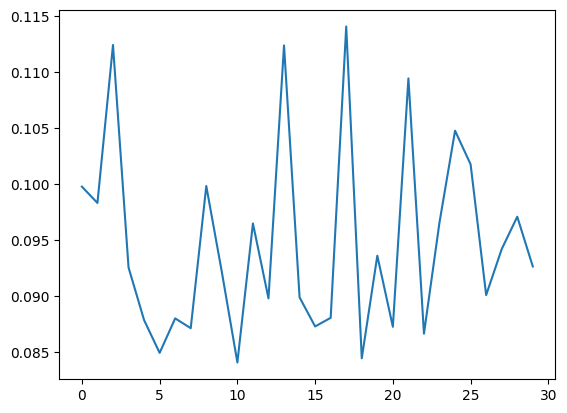

In [17]:
plt.plot(valid_losses)
plt.show()

# category classification

In [18]:
for param in bert.parameters():
    param.requires_grad = False

class second(nn.Module):

    def __init__(self, amount_of_classes, amount_of_classes_2):
        super(second, self).__init__()

        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768 + amount_of_classes ,1024)
        self.fc2 = nn.Linear(1024,amount_of_classes_2)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, cls_hs, target_1):
        #cls_hs is pooler output in docs
        #_, cls_hs = self.bert(sent_id, attention_mask = mask, return_dict = False)
#         print(cls_hs.shape, target_1.shape)
        concated = (torch.cat((cls_hs, target_1), 1))
        x = self.fc1(concated)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [19]:
epochs = 20

cross_entropy = nn.CrossEntropyLoss()
# cross_entropy = nn.KLDivLoss(reduction="batchmean")

model_second = second(amount_of_classes, amount_of_classes_2)

model_second = model_second.to(device)
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr= 1e-3)

model_2_path = os.path.join('..', 'model', 'model2.pt')

C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [20]:
def evaluate_second():
    model_second.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []

    for step, batch in tqdm(enumerate(val_dataloader), total = len(val_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        
        #my bad code
        labels= list(labels.cpu().numpy())
        corr_answ = []
        for label in labels:
            label = list(label[amount_of_classes:])
            corr_answ.append(label.index(1))
        corr_answ = torch.tensor(corr_answ).to(device)
            

        with torch.no_grad():
            _, cls_hs = bert(sent_id, attention_mask = mask, return_dict = False)

            target_1 = model(cls_hs)
            preds = model_second(cls_hs, target_1)

            #labels = torch.argmax(labels, dim=1)

            loss = cross_entropy(preds, corr_answ)

            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)
            
            
            


    avg_loss = total_loss / len(val_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)

    return avg_loss, total_preds


In [21]:
def train_second():
    model_second.train()
    total_loss, total_accuracy = 0, 0
    total_preds = []

    for step, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        batch = [r.to(device) for r in batch]
        sent_id,mask,labels = batch
        
        labels= list(labels.cpu().numpy())
        corr_answ = []
        for label in labels:
            label = list(label[amount_of_classes:])
            corr_answ.append(label.index(1))
        corr_answ = torch.tensor(corr_answ).to(device)
        
#         print('correct answers (indexes):', corr_answ)
#         print('labels:', labels)
        
        model_second.zero_grad()
        _, cls_hs = bert(sent_id, attention_mask = mask, return_dict = False)
        target_1 = model(cls_hs)
        
        preds = model_second(cls_hs, target_1)

#         for i in range(len(corr_answ)):
            
        
        loss = cross_entropy(preds, corr_answ)

        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)
        

    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)

    return avg_loss, total_preds

In [22]:
best_valid_loss = float('inf')

train_losses = []
valid_losses = []

for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))

    train_loss, _ = train_second()
    valid_loss, _ = evaluate_second()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        print('saving...')
        torch.save(model_second.state_dict(), model_2_path)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Validation loss: {valid_loss:.3f}')


 Epoch1 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 87.17it/s]


saving...

Training loss: 3.137
Validation loss: 2.722

 Epoch2 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 87.36it/s]


saving...

Training loss: 2.700
Validation loss: 2.519

 Epoch3 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 87.40it/s]


saving...

Training loss: 2.578
Validation loss: 2.444

 Epoch4 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 87.48it/s]


saving...

Training loss: 2.507
Validation loss: 2.383

 Epoch5 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 87.47it/s]


saving...

Training loss: 2.467
Validation loss: 2.340

 Epoch6 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 87.32it/s]


saving...

Training loss: 2.432
Validation loss: 2.326

 Epoch7 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 87.31it/s]


saving...

Training loss: 2.403
Validation loss: 2.267

 Epoch8 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 87.37it/s]



Training loss: 2.382
Validation loss: 2.269

 Epoch9 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 87.44it/s]


saving...

Training loss: 2.361
Validation loss: 2.247

 Epoch10 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 87.38it/s]


saving...

Training loss: 2.337
Validation loss: 2.232

 Epoch11 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 87.46it/s]



Training loss: 2.320
Validation loss: 2.250

 Epoch12 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 87.37it/s]


saving...

Training loss: 2.311
Validation loss: 2.225

 Epoch13 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 87.34it/s]


saving...

Training loss: 2.298
Validation loss: 2.179

 Epoch14 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 87.32it/s]



Training loss: 2.289
Validation loss: 2.209

 Epoch15 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 87.33it/s]



Training loss: 2.276
Validation loss: 2.197

 Epoch16 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 87.39it/s]



Training loss: 2.264
Validation loss: 2.187

 Epoch17 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 87.41it/s]


saving...

Training loss: 2.259
Validation loss: 2.169

 Epoch18 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 86.70it/s]



Training loss: 2.246
Validation loss: 2.172

 Epoch19 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 87.32it/s]



Training loss: 2.233
Validation loss: 2.181

 Epoch20 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 87.32it/s]

saving...

Training loss: 2.229
Validation loss: 2.167


In [23]:

model_second.load_state_dict(torch.load(model_2_path))

<All keys matched successfully>

In [24]:
#my evaluation after training

model_second.eval()
model_second.to(device)
count_true = 0
count_total = 1
for step, batch in tqdm(enumerate(test_dataloader), total = len(test_dataloader)):
    batch = [t.to(device) for t in batch]
    sent_id, mask, labels = batch

    with torch.no_grad():
        _, cls_hs = bert(sent_id, attention_mask = mask, return_dict = False)
        target_1 = model(cls_hs)
        preds=model_second(cls_hs, target_1)
        preds = torch.argmax(preds, dim=1)
        preds = preds.cpu().numpy()

    labels = list(labels)


    for index in range(len(preds)):        
        correct = list(labels[index][amount_of_classes:].cpu().numpy()).index(1)

        count_total += 1
        tmp1 = [0] * amount_of_classes_2

        
        tmp2 = [0] * amount_of_classes_2
        tmp2[correct] = 1
        tmp1, tmp2 = torch.tensor([tmp1]), torch.tensor([tmp2])
        #print(tokenizer.convert_ids_to_tokens(sent_id[index]))
        if preds[index] == correct:
            count_true += 1
            

print(count_true/count_total)
        
        

100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:15<00:00, 83.90it/s]

0.5618197862535542


In [ ]:
!

In [25]:
import pickle

encoders = {'path1': model_1_path, 'path2':model_2_path, 'encoder1': encoder, 'encoder2':encoder_2, 
            'num_classes1': amount_of_classes, 'num_classes2':amount_of_classes_2}

pickle_path = os.path.join('..', 'model', 'encoders.pkl')
with open(pickle_path, "wb") as f:
    pickle.dump(encoders, f)

In [26]:
print(encoders)

{'path1': '..\\model\\model1.pt', 'path2': '..\\model\\model2.pt', 'encoder1': LabelBinarizer(), 'encoder2': LabelBinarizer(), 'num_classes1': 22, 'num_classes2': 97}
